# Data Preparation for the Models

In [2]:
import pandas as pd
import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier

## Data Filtering and Preprocessing

We aim at predicting "is_recid". Some features in the dataset must be droped in order to remove features that might be directly linked to the target value, such as "is_violent_recid"

In [3]:
df = utils.read_data_files()
df = df.drop(df[df.is_recid == -1].index)

In [4]:
FEATURES = ['sex', 'age', 'age_cat', 'race',
            'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count',
            'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
            'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 
            'score_text', 'screening_date',
            'v_decile_score', 'v_score_text',
            'event']

TARGET = ['is_recid']

In [5]:
# Label encode categorical columns
df_encoded = df[FEATURES + TARGET].copy()
label_encoders = {}

for column in df_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column].astype(str))
    label_encoders[column] = le  # Store the label encoder for each column

# Now all columns should be numeric
X = df_encoded.drop('is_recid', axis=1)
y = df_encoded['is_recid']

In [6]:
# Handle missing values if any
X.fillna(X.mean(), inplace=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Models

### RandomForest Classifier

In [7]:
blackbox_model = RandomForestClassifier(random_state=42)
blackbox_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## STEP 5 

### Partial Dependance Plot (PDP)

In [8]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

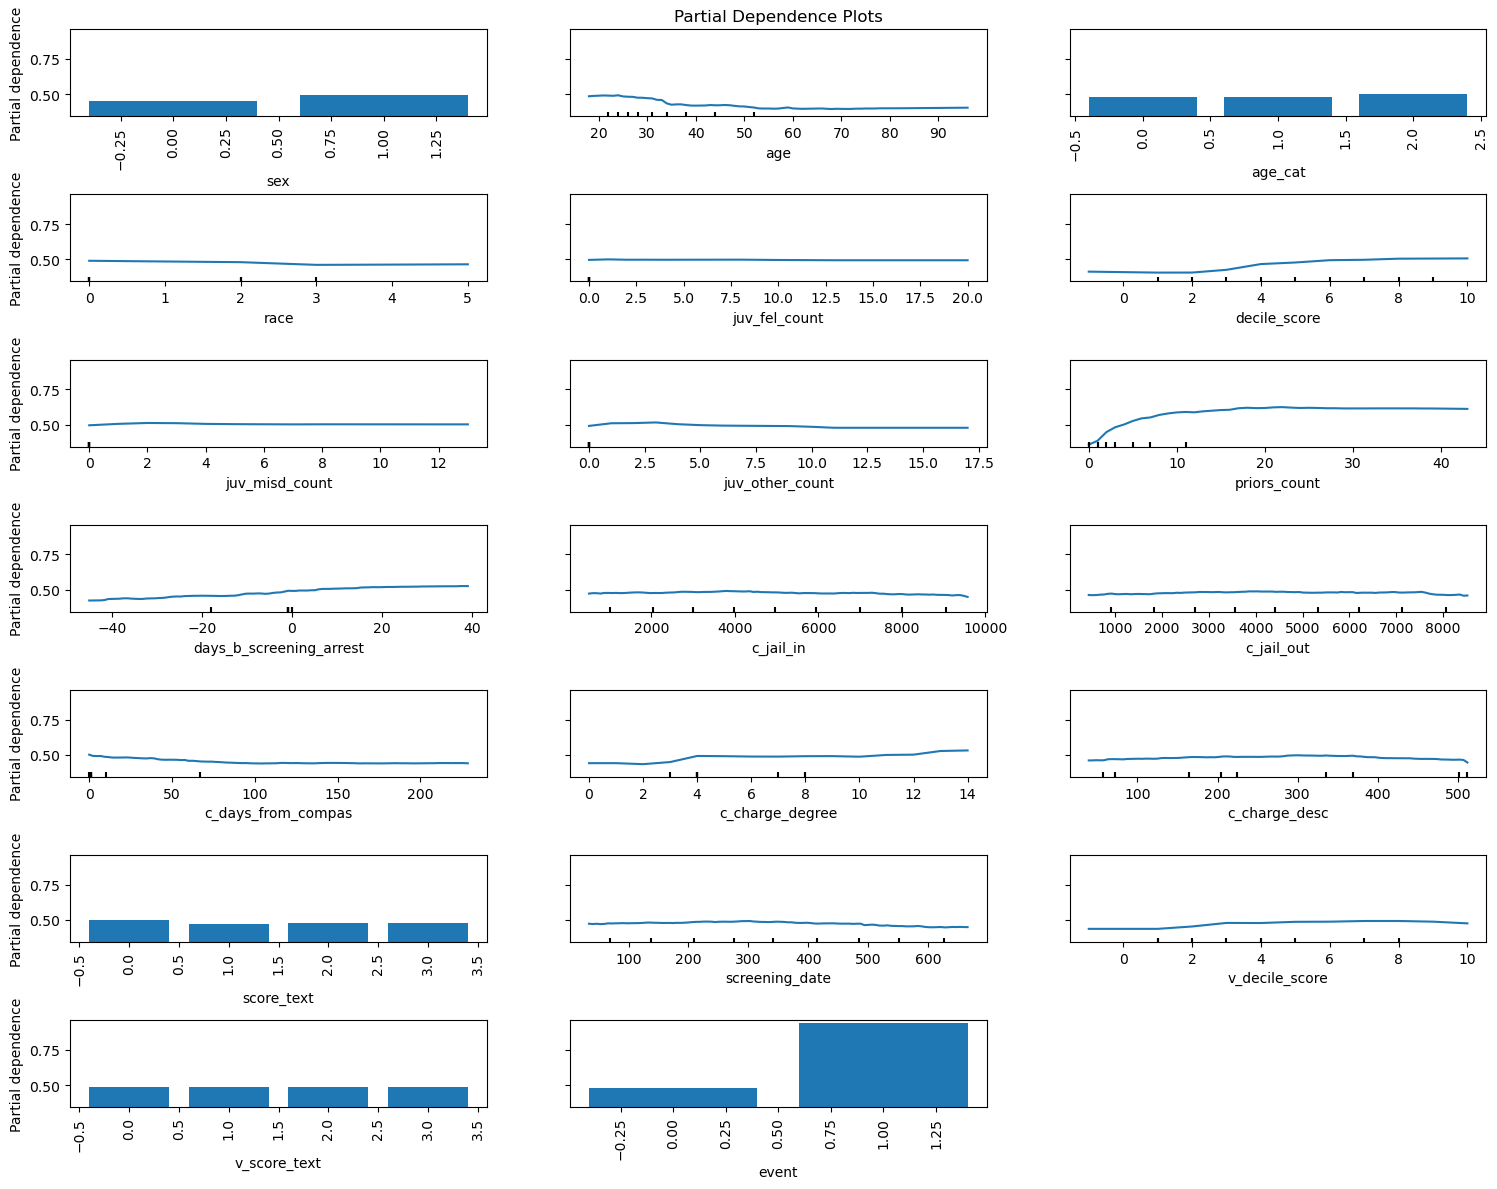

In [9]:
# Assuming 'X' is your features dataframe and 'cat_model' is your trained model.

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(15, 12))

# List of features
features = list(range(X.shape[1]))

# List of boolean values where True indicates a categorical feature
cat_list = (X.nunique() < 5).tolist()

# Generate the partial dependence plots for all features on the specified axis
display = PartialDependenceDisplay.from_estimator(
    blackbox_model, 
    X, 
    features, 
    categorical_features=cat_list,
    ax=ax  # Here you pass the ax object to the function
)

# Optional: Customize the display, for example by setting a title
ax.set_title('Partial Dependence Plots')
fig.tight_layout()
fig.subplots_adjust(hspace=0.9)

# Show the plot
plt.show()


### Accumulated Local Effect

In [ ]:
import random
import matplotlib.pyplot as plt
from PyALE import ale

# Assuming 'X' is your features dataframe and 'cat_model' is your trained model.
# Assuming 'features' is a list of all feature names in your dataframe.
features = list(X.columns)
# Determine the number of rows and columns for the subplots
n_cols = 3  # Set the desired number of columns
n_rows = (len(features) + n_cols - 1) // n_cols  # Compute the necessary number of rows

# Set up the figure with a grid of subplots
#fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 12), squeeze=False)


# Iterate over all features and plot the ALE for each one
for i, feature in enumerate(features):
    ax = axs.flatten()[i]
    if cat_list[i]:  # If the feature is categorical
        ale_eff =  ale(X=X[features], model=blackbox_model, feature=[feature])
    else:  # If the feature is continuous
        ale_eff = ale(
            X=X_sample, model=blackbox_model, feature=[feature], grid_size=50, include_CI=False)

#    # Set the title for each ALE plot
#    ax.set_title(f'ALE of feature: {feature}')

# Hide any unused subplots
#for i in range(len(features), len(axs.flatten())):
#    axs.flatten()[i].set_visible(False)

# Adjust the layout
#fig.tight_layout()
#fig.subplots_adjust(hspace=0.9)  # Adjust the vertical space between plots

# Show the plot
#plt.show()


: 